<a href="https://colab.research.google.com/github/Rafian666/Pneumonia_Detection/blob/main/Pneumonia_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Loading Libraries

In [ ]:
from __future__ import absolute_import, division, print_function
import numpy as np
import pandas as pd

import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

import keras
from keras import regularizers
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Conv2D,MaxPooling2D,Dense,Flatten,Dropout

from sklearn.metrics import accuracy_score
from random import shuffle
from tqdm import tqdm
import scipy
import skimage
from skimage.transform import resize
import random

import os

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Import Dataset

In [ ]:
data=[]
labels=[]
Pneumonia=os.listdir("/content/drive/MyDrive/Colab Notebooks/chest_xray/train/PNEUMONIA/")
for a in Pneumonia:
    try:
        image=cv2.imread("/content/drive/MyDrive/Colab Notebooks/chest_xray/train/PNEUMONIA/"+a)
        image_from_array = Image.fromarray(image, 'RGB')
        size_image = image_from_array.resize((50, 50))
        data.append(np.array(size_image))
        labels.append(0)
    except AttributeError:
        print("")

Normal=os.listdir("/content/drive/MyDrive/Colab Notebooks/chest_xray/train/NORMAL/")
for b in Normal:
    try:
        image=cv2.imread("/content/drive/MyDrive/Colab Notebooks/chest_xray/train/NORMAL/"+b)
        image_from_array = Image.fromarray(image, 'RGB')
        size_image = image_from_array.resize((50, 50))
        data.append(np.array(size_image))
        labels.append(1)
    except AttributeError:
        print("")

In [ ]:
infection=np.array(data)
labels=np.array(labels)

In [ ]:
np.save("infection",infection)
np.save("labels",labels)

In [ ]:
print('Pneumonia : {} | labels : {}'.format(infection.shape , labels.shape))

Pneumonia : (2512, 50, 50, 3) | labels : (2512,)


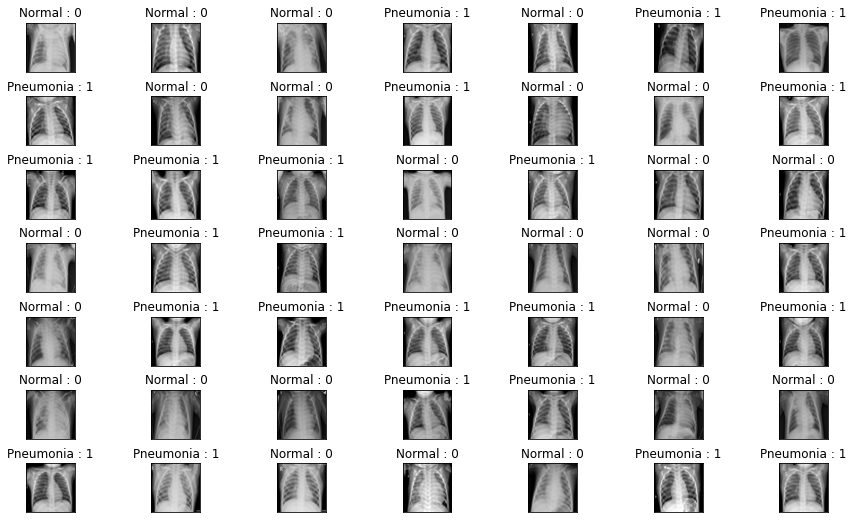

In [ ]:
plt.figure(1 , figsize = (15 , 9))
n = 0
for i in range(49):
    n += 1
    r = np.random.randint(0 , infection.shape[0] , 1)
    plt.subplot(7 , 7 , n)
    plt.subplots_adjust(hspace = 0.5 , wspace = 0.5)
    plt.imshow(infection[r[0]])
    plt.title('{} : {}'.format('Pneumonia' if labels[r[0]] == 1 else 'Normal' ,
                               labels[r[0]]) )
    plt.xticks([]) , plt.yticks([])

plt.show()

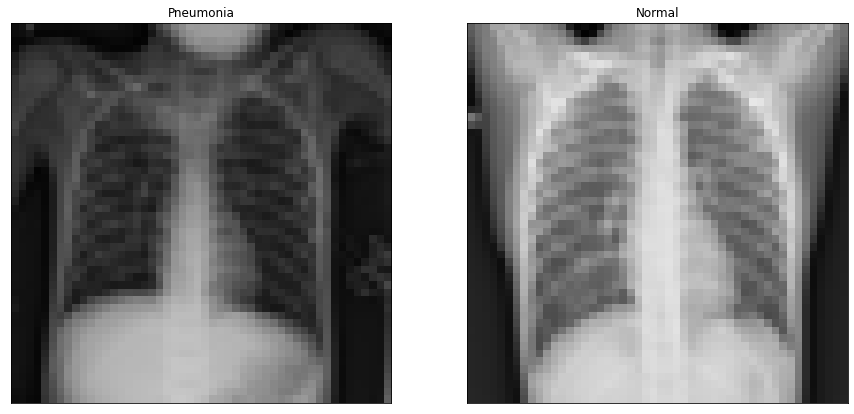

In [ ]:
plt.figure(1, figsize = (15 , 7))
plt.subplot(1 , 2 , 1)
plt.imshow(infection[0])
plt.title('Pneumonia')
plt.xticks([]) , plt.yticks([])

plt.subplot(1 , 2 , 2)
plt.imshow(infection[2000])
plt.title('Normal')
plt.xticks([]) , plt.yticks([])

plt.show()

In [ ]:
s=np.arange(infection.shape[0])
np.random.shuffle(s)
infection=infection[s]
labels=labels[s]

In [ ]:
num_classes=len(np.unique(labels))
len_data=len(infection)

In [ ]:
(x_train,x_test)=infection[(int)(0.1*len_data):],infection[:(int)(0.1*len_data)]
x_train = x_train.astype('float32')/255 # As we are working on image data we are normalizing data by divinding 255.
x_test = x_test.astype('float32')/255
train_len=len(x_train)
test_len=len(x_test)

In [ ]:
(y_train,y_test)=labels[(int)(0.1*len_data):],labels[:(int)(0.1*len_data)]

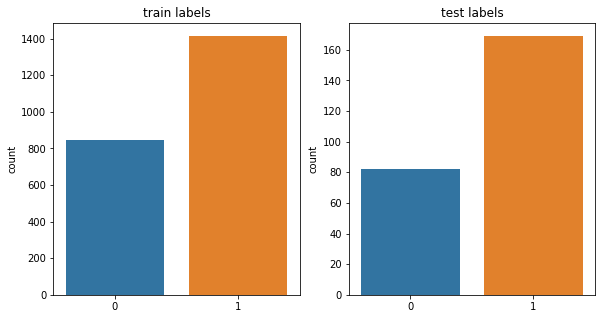

In [ ]:
plt.figure(1 , figsize = (15 ,5))
n = 0
for z , j in zip([y_train ,  y_test] , ['train labels','test labels']):
    n += 1
    plt.subplot(1 , 3  , n)
    sns.countplot(x = z )
    plt.title(j)
plt.show()

In [ ]:
print('train data shape {} , test data shape {}'.format(x_train.shape,
                                                        x_test.shape))

train data shape (2261, 50, 50, 3) , test data shape (251, 50, 50, 3)


In [ ]:
#Doing One hot encoding as classifier has multiple classes
y_train=keras.utils.np_utils.to_categorical(y_train,num_classes)
y_test=keras.utils.np_utils.to_categorical(y_test,num_classes)

# Data Augmentation

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images

datagen.fit(x_train)

# Early stopping

In [ ]:
from keras.callbacks import EarlyStopping
earlystop= EarlyStopping(monitor='val_acc', patience=3)
epochs = 20 #
batch_size = 32

# Keras Model

In [ ]:
#creating sequential model
model=Sequential()
model.add(Conv2D(filters=16,kernel_size=2,padding="same",activation="relu",input_shape=(50,50,3)))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=32,kernel_size=2,padding="same",activation="relu"))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=64,kernel_size=2,padding="same",activation="relu"))
model.add(MaxPooling2D(pool_size=2))
# 1st dropout
model.add(Dropout(0.2))
model.add(Flatten())
#l2 regularizer
model.add(Dense(500,kernel_regularizer=regularizers.l2(0.01),activation="relu"))
# 2nd dropout
model.add(Dropout(0.2))
model.add(Dense(2,activation="softmax"))#2 represent output layer neurons
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 50, 50, 16)        208       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 25, 25, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 25, 25, 32)        2080      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 12, 12, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 12, 12, 64)        8256      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 6, 6, 64)         0

In [ ]:
# Compiling model
# compile the model with loss as categorical_crossentropy and using adam optimizer you can test result by trying RMSProp as well as Momentum
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
# Fit the model
history = model.fit_generator(datagen.flow(x_train,y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (x_test,y_test),
                              verbose = 1, steps_per_epoch=x_train.shape[0] // batch_size
                              , callbacks=[earlystop])

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  """


70/70 [==============================] - ETA: 0s - loss: 0.2608 - accuracy: 0.9134

70/70 [==============================] - 7s 96ms/step - loss: 0.2608 - accuracy: 0.9134 - val_loss: 0.1986 - val_accuracy: 0.9323
Epoch 2/20
70/70 [==============================] - ETA: 0s - loss: 0.2665 - accuracy: 0.9179

70/70 [==============================] - 7s 95ms/step - loss: 0.2665 - accuracy: 0.9179 - val_loss: 0.1734 - val_accuracy: 0.9482
Epoch 3/20
70/70 [==============================] - ETA: 0s - loss: 0.2509 - accuracy: 0.9242

70/70 [==============================] - 7s 97ms/step - loss: 0.2509 - accuracy: 0.9242 - val_loss: 0.1628 - val_accuracy: 0.9522
Epoch 4/20
70/70 [==============================] - ETA: 0s - loss: 0.2522 - accuracy: 0.9246

70/70 [==============================] - 7s 96ms/step - loss: 0.2522 - accuracy: 0.9246 - val_loss: 0.1890 - val_accuracy: 0.9442
Epoch 5/20
70/70 [==============================] - ETA: 0s - loss: 0.2648 - accuracy: 0.9148

70/70 [==============================] - 7s 96ms/step - loss: 0.2648 - accuracy: 0.9148 - val_loss: 0.1810 - val_accuracy: 0.9442
Epoch 6/20
70/70 [==============================] - ETA: 0s - loss: 0.2438 - accuracy: 0.9269

70/70 [==============================] - 7s 95ms/step - loss: 0.2438 - accuracy: 0.9269 - val_loss: 0.1622 - val_accuracy: 0.9602
Epoch 7/20
70/70 [==============================] - ETA: 0s - loss: 0.2600 - accuracy: 0.9197

70/70 [==============================] - 7s 97ms/step - loss: 0.2600 - accuracy: 0.9197 - val_loss: 0.2283 - val_accuracy: 0.9163
Epoch 8/20
70/70 [==============================] - ETA: 0s - loss: 0.2466 - accuracy: 0.9260

70/70 [==============================] - 7s 97ms/step - loss: 0.2466 - accuracy: 0.9260 - val_loss: 0.1939 - val_accuracy: 0.9402
Epoch 9/20
70/70 [==============================] - ETA: 0s - loss: 0.2536 - accuracy: 0.9255

70/70 [==============================] - 7s 97ms/step - loss: 0.2536 - accuracy: 0.9255 - val_loss: 0.1728 - val_accuracy: 0.9522
Epoch 10/20
70/70 [==============================] - ETA: 0s - loss: 0.2491 - accuracy: 0.9228

70/70 [==============================] - 7s 96ms/step - loss: 0.2491 - accuracy: 0.9228 - val_loss: 0.1931 - val_accuracy: 0.9402
Epoch 11/20
70/70 [==============================] - ETA: 0s - loss: 0.2466 - accuracy: 0.9215

70/70 [==============================] - 7s 97ms/step - loss: 0.2466 - accuracy: 0.9215 - val_loss: 0.1886 - val_accuracy: 0.9522
Epoch 12/20
70/70 [==============================] - ETA: 0s - loss: 0.2582 - accuracy: 0.9152

70/70 [==============================] - 7s 97ms/step - loss: 0.2582 - accuracy: 0.9152 - val_loss: 0.1851 - val_accuracy: 0.9482
Epoch 13/20
70/70 [==============================] - ETA: 0s - loss: 0.2812 - accuracy: 0.9076

70/70 [==============================] - 7s 97ms/step - loss: 0.2812 - accuracy: 0.9076 - val_loss: 0.2136 - val_accuracy: 0.9363
Epoch 14/20
70/70 [==============================] - ETA: 0s - loss: 0.2427 - accuracy: 0.9260

70/70 [==============================] - 7s 96ms/step - loss: 0.2427 - accuracy: 0.9260 - val_loss: 0.1754 - val_accuracy: 0.9522
Epoch 15/20
70/70 [==============================] - ETA: 0s - loss: 0.2215 - accuracy: 0.9323

70/70 [==============================] - 7s 97ms/step - loss: 0.2215 - accuracy: 0.9323 - val_loss: 0.1680 - val_accuracy: 0.9522
Epoch 16/20
70/70 [==============================] - ETA: 0s - loss: 0.2533 - accuracy: 0.9143

70/70 [==============================] - 7s 96ms/step - loss: 0.2533 - accuracy: 0.9143 - val_loss: 0.1889 - val_accuracy: 0.9442
Epoch 17/20
70/70 [==============================] - ETA: 0s - loss: 0.2470 - accuracy: 0.9251

70/70 [==============================] - 7s 97ms/step - loss: 0.2470 - accuracy: 0.9251 - val_loss: 0.1868 - val_accuracy: 0.9522
Epoch 18/20
70/70 [==============================] - ETA: 0s - loss: 0.2263 - accuracy: 0.9318

70/70 [==============================] - 7s 96ms/step - loss: 0.2263 - accuracy: 0.9318 - val_loss: 0.2000 - val_accuracy: 0.9323
Epoch 19/20
70/70 [==============================] - ETA: 0s - loss: 0.2323 - accuracy: 0.9269

70/70 [==============================] - 7s 96ms/step - loss: 0.2323 - accuracy: 0.9269 - val_loss: 0.1734 - val_accuracy: 0.9442
Epoch 20/20
70/70 [==============================] - ETA: 0s - loss: 0.2447 - accuracy: 0.9197

70/70 [==============================] - 7s 97ms/step - loss: 0.2447 - accuracy: 0.9197 - val_loss: 0.2104 - val_accuracy: 0.9363


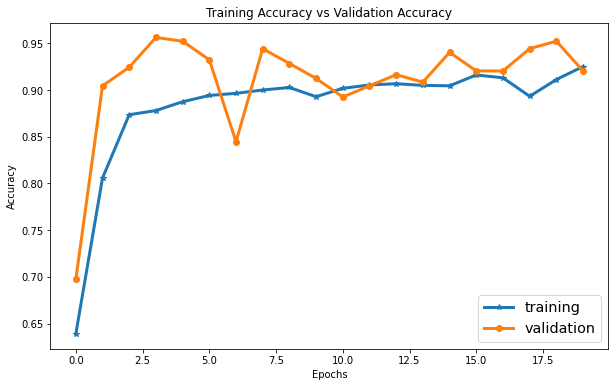

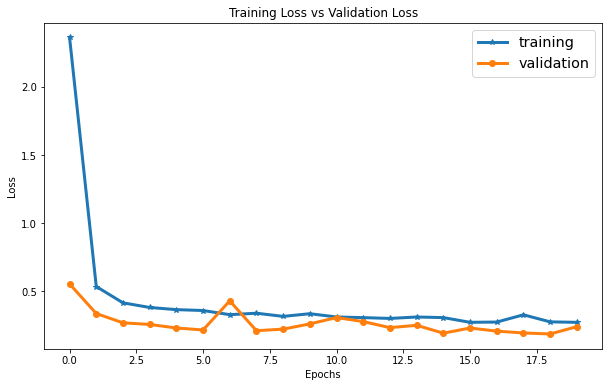

In [ ]:
def visualize_training(history, lw = 3):
    plt.figure(figsize=(10,6))
    plt.plot(history.history['accuracy'], label = 'training', marker = '*', linewidth = lw)
    plt.plot(history.history['val_accuracy'], label = 'validation', marker = 'o', linewidth = lw)
    plt.title('Training Accuracy vs Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(fontsize = 'x-large')
    plt.show()

    plt.figure(figsize=(10,6))
    plt.plot(history.history['loss'], label = 'training', marker = '*', linewidth = lw)
    plt.plot(history.history['val_loss'], label = 'validation', marker = 'o', linewidth = lw)
    plt.title('Training Loss vs Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(fontsize = 'x-large')
    plt.show()
visualize_training(history)

# Confusion Matrix

In [ ]:
from sklearn.metrics import confusion_matrix
pred = model.predict(x_test)
pred = np.argmax(pred,axis = 1)
y_true = np.argmax(y_test,axis = 1)

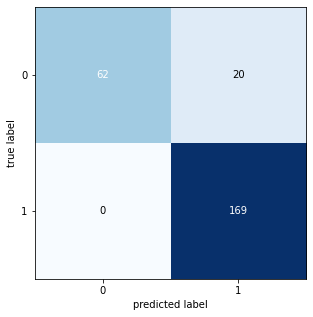

In [ ]:
CM = confusion_matrix(y_true, pred)
from mlxtend.plotting import plot_confusion_matrix
fig, ax = plot_confusion_matrix(conf_mat=CM ,  figsize=(5, 5))
plt.show()

In [ ]:
# Calculate Precision and Recall
tn, fp, fn, tp = CM.ravel()

accuracy = (tp+tn)/(tp+tn+fp+fn)
precision = tp/(tp+fp)
recall = tp/(tp+fn)

print("Accuracy of the model is {:.2f}".format(accuracy))
print("Recall of the model is {:.2f}".format(recall))
print("Precision of the model is {:.2f}".format(precision))

Accuracy of the model is 0.92
Recall of the model is 1.00
Precision of the model is 0.89
